In [1]:
random_state=1
verbosity=0
version=1

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def get_pipeline(booster, n_estimators, max_depth, learning_rate, random_state, verbosity):
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(booster=booster, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state,verbosity=verbosity))
    ])

def get_score(X, y, params):
    """Return the average MAE over 3 CV folds of xgboost model.

    Keyword argument:
    X -- X values
    y -- y values
    params -- params for model
    """
    pipeline = get_pipeline(params['booster'], params['n_estimators'], params['max_depth'], params['learning_rate'], params['random_state'], params['verbosity'])

    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error', verbose=verbosity)
    return scores.mean()

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, title='Mutual Information Scores'):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(title)
    plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import GridSearchCV

train_data = pd.read_csv(filepath_or_buffer='../inputs/train.csv')
train_has_na = train_data.isnull().values.any()
print('Train has null values' if train_has_na else 'Train doesn\'t have null values')

print('Train data types: \n', train_data.dtypes)

y_features = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
X_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
X = train_data[X_features]
y_all = train_data[y_features]

print('X data types: \n', X.dtypes)

print('First rows in X:\n', X.head())
print('Length of training data: ', len(X))

test_data = pd.read_csv('../inputs/test.csv')
test_has_na = test_data.isnull().values.any()
print('Test has null values' if test_has_na else 'Test doesn\'t have null values')

print('Test data types: \n', test_data.dtypes)

test_X = test_data[X_features]
print('Length of test data: ', len(test_X))

print('Params of XGBRegressor: ', XGBRegressor())
parameters = [
    {'booster': ['gbtree', 'gblinear', 'dart', None], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6, None], 'learning_rate': [0.05, 0.1, 0.15, None], 'random_state': [random_state], 'verbosity': [verbosity]}
]
grid = GridSearchCV(estimator=XGBRegressor(), param_grid=parameters, verbose=verbosity, cv=3, scoring='neg_mean_absolute_error')

old_val_maes = old_val_maes if 'old_val_maes' in vars() else {}
for y_feature in y_features:
    old_val_maes[y_feature] = old_val_maes[y_feature] if y_feature in old_val_maes else -1

predictions = {}

Train doesn't have null values
Train data types: 
 date_time                  object
deg_C                     float64
relative_humidity         float64
absolute_humidity         float64
sensor_1                  float64
sensor_2                  float64
sensor_3                  float64
sensor_4                  float64
sensor_5                  float64
target_carbon_monoxide    float64
target_benzene            float64
target_nitrogen_oxides    float64
dtype: object
X data types: 
 deg_C                float64
relative_humidity    float64
absolute_humidity    float64
sensor_1             float64
sensor_2             float64
sensor_3             float64
sensor_4             float64
sensor_5             float64
dtype: object
First rows in X:
    deg_C  relative_humidity  absolute_humidity  sensor_1  sensor_2  sensor_3  \
0   13.1               46.0             0.7578    1387.2    1087.8    1056.0   
1   13.2               45.3             0.7255    1279.1     888.2    1197.5   
2   12.

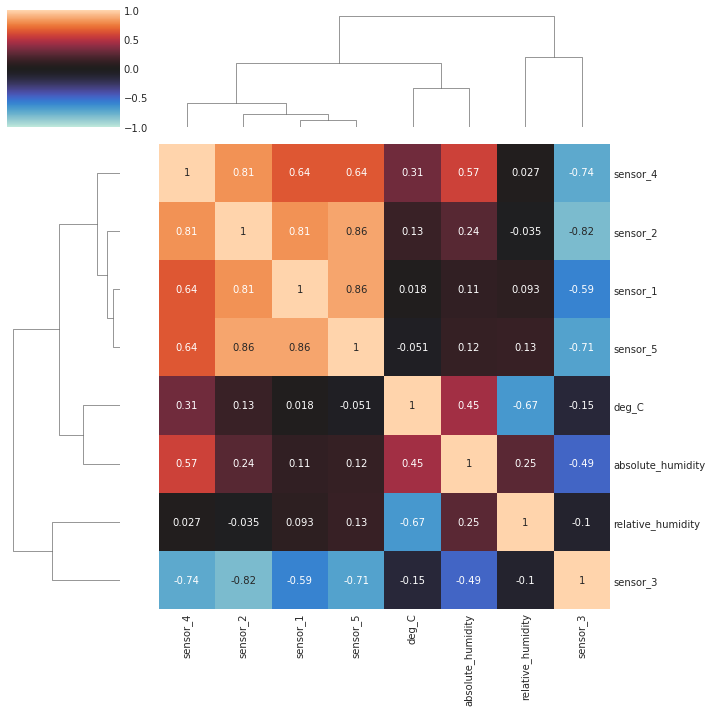

In [4]:
import seaborn as sns

sns.clustermap(
    X.corr('pearson'),
    vmin=-1.0,
    vmax=1.0,
    cmap='icefire',
    method='complete',
    annot=True
)

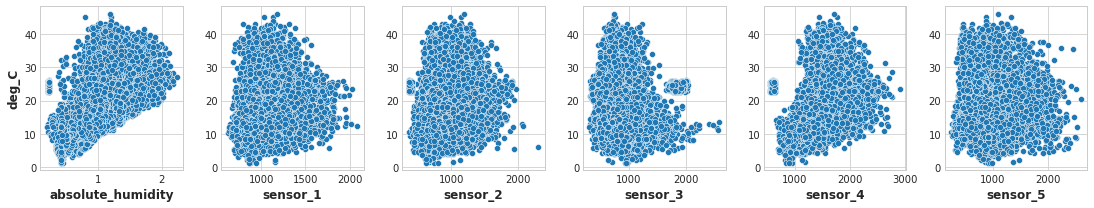

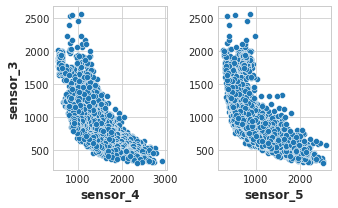

In [5]:
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(15.3, 3))
sns.scatterplot(x='absolute_humidity', y='deg_C', data=X, ax=ax1)
sns.scatterplot(x='sensor_1', y='deg_C', data=X, ax=ax2).set(ylabel=None)
sns.scatterplot(x='sensor_2', y='deg_C', data=X, ax=ax3).set(ylabel=None)
sns.scatterplot(x='sensor_3', y='deg_C', data=X, ax=ax4).set(ylabel=None)
sns.scatterplot(x='sensor_4', y='deg_C', data=X, ax=ax5).set(ylabel=None)
sns.scatterplot(x='sensor_5', y='deg_C', data=X, ax=ax6).set(ylabel=None)
plt.show()

_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(12.6, 3))
sns.scatterplot(x='sensor_1', y='absolute_humidity', data=X, ax=ax1)
sns.scatterplot(x='sensor_2', y='absolute_humidity', data=X, ax=ax2).set(ylabel=None)
sns.scatterplot(x='sensor_3', y='absolute_humidity', data=X, ax=ax3).set(ylabel=None)
sns.scatterplot(x='sensor_4', y='absolute_humidity', data=X, ax=ax4).set(ylabel=None)
sns.scatterplot(x='sensor_5', y='absolute_humidity', data=X, ax=ax5).set(ylabel=None)
plt.show()

_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(10, 3))
sns.scatterplot(x='sensor_2', y='sensor_1', data=X, ax=ax1)
sns.scatterplot(x='sensor_3', y='sensor_1', data=X, ax=ax2).set(ylabel=None)
sns.scatterplot(x='sensor_4', y='sensor_1', data=X, ax=ax3).set(ylabel=None)
sns.scatterplot(x='sensor_5', y='sensor_1', data=X, ax=ax4).set(ylabel=None)
plt.show()

_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(7.4, 3))
sns.scatterplot(x='sensor_3', y='sensor_2', data=X, ax=ax1)
sns.scatterplot(x='sensor_4', y='sensor_2', data=X, ax=ax2).set(ylabel=None)
sns.scatterplot(x='sensor_5', y='sensor_2', data=X, ax=ax3).set(ylabel=None)
plt.show()

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4.8, 3))
sns.scatterplot(x='sensor_4', y='sensor_3', data=X, ax=ax1)
sns.scatterplot(x='sensor_5', y='sensor_3', data=X, ax=ax2).set(ylabel=None)
plt.show()

_, (ax1) = plt.subplots(ncols=1, figsize=(2.15, 3))
sns.scatterplot(x='sensor_5', y='sensor_4', data=X, ax=ax1)
plt.show()

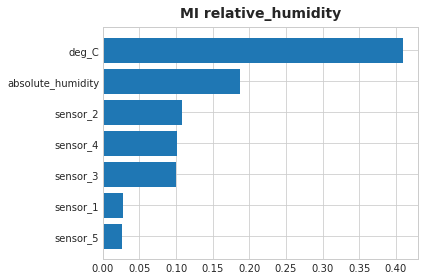

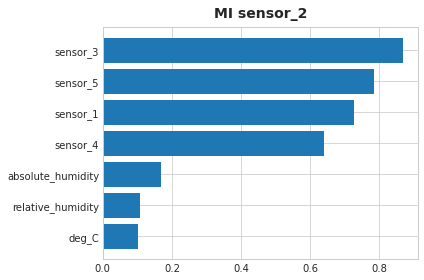

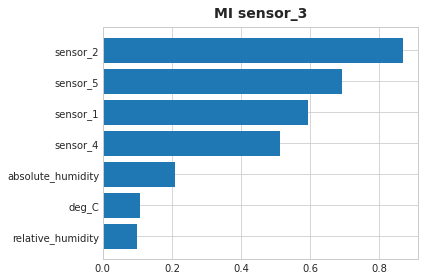

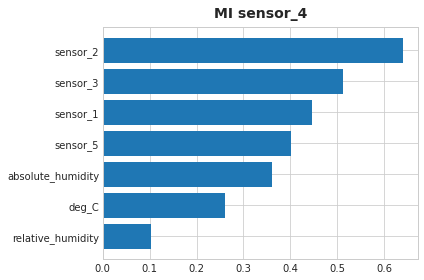

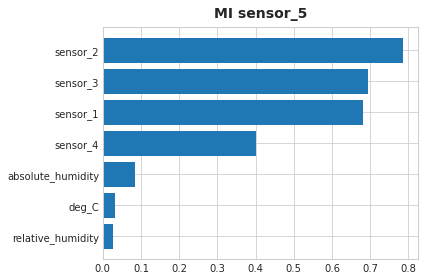

In [6]:
mi_scores = make_mi_scores(X[X.columns[X.columns!='deg_C']], X['deg_C'])
plot_mi_scores(mi_scores, 'MI deg_C')

mi_scores = make_mi_scores(X[X.columns[X.columns!='absolute_humidity']], X['absolute_humidity'])
plot_mi_scores(mi_scores, 'MI absolute_humidity')

mi_scores = make_mi_scores(X[X.columns[X.columns!='relative_humidity']], X['relative_humidity'])
plot_mi_scores(mi_scores, 'MI relative_humidity')

mi_scores = make_mi_scores(X[X.columns[X.columns!='sensor_1']], X['sensor_1'])
plot_mi_scores(mi_scores, 'MI sensor_1')

mi_scores = make_mi_scores(X[X.columns[X.columns!='sensor_2']], X['sensor_2'])
plot_mi_scores(mi_scores, 'MI sensor_2')

mi_scores = make_mi_scores(X[X.columns[X.columns!='sensor_3']], X['sensor_3'])
plot_mi_scores(mi_scores, 'MI sensor_3')

mi_scores = make_mi_scores(X[X.columns[X.columns!='sensor_4']], X['sensor_4'])
plot_mi_scores(mi_scores, 'MI sensor_4')

mi_scores = make_mi_scores(X[X.columns[X.columns!='sensor_5']], X['sensor_5'])
plot_mi_scores(mi_scores, 'MI sensor_5')

In [7]:
mi_scores = make_mi_scores(y_all[y_all.columns[y_all.columns!='target_carbon_monoxide']], y_all['target_carbon_monoxide'])
plot_mi_scores(mi_scores, 'MI target_carbon_monoxide')

mi_scores = make_mi_scores(y_all[y_all.columns[y_all.columns!='target_benzene']], y_all['target_benzene'])
plot_mi_scores(mi_scores, 'MI target_benzene')

mi_scores = make_mi_scores(y_all[y_all.columns[y_all.columns!='target_nitrogen_oxides']], y_all['target_nitrogen_oxides'])
plot_mi_scores(mi_scores, 'MI target_nitrogen_oxides')

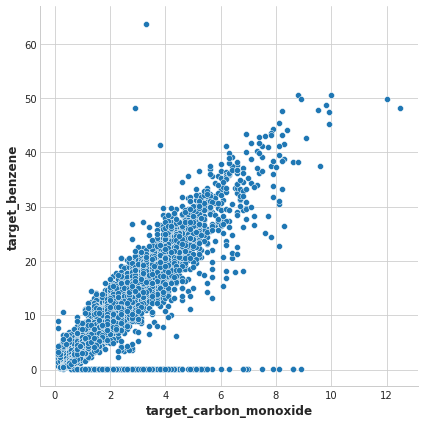

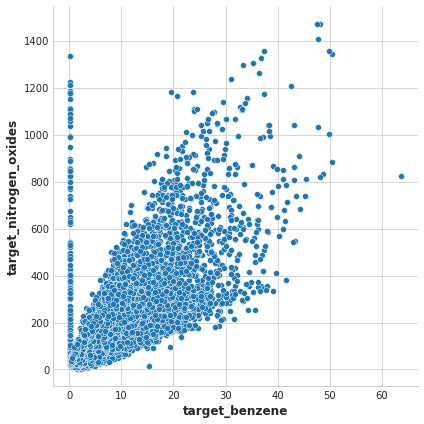

In [8]:
sns.relplot(
    x='target_carbon_monoxide', y='target_benzene', data=y_all, height=6,
)
sns.relplot(
    x='target_carbon_monoxide', y='target_nitrogen_oxides', data=y_all, height=6,
)

sns.relplot(
    x='target_benzene', y='target_nitrogen_oxides', data=y_all, height=6,
)

   deg_C  absolute_humidity cluster
0   13.1             0.7578       2
1   13.2             0.7255       2
2   12.6             0.7502       2
3   11.0             0.7867       2
4   11.9             0.7888       2


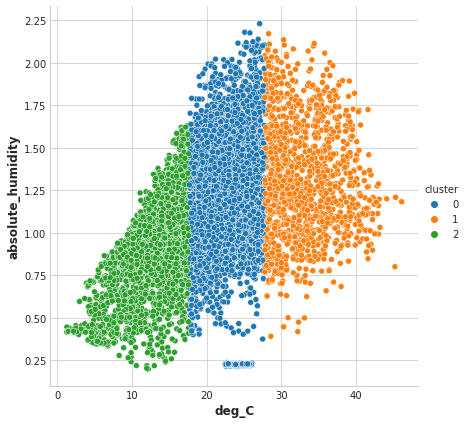

In [9]:
from sklearn.cluster import KMeans

hum_and_deg = pd.DataFrame({'deg_C': X.deg_C,
                            'absolute_humidity': X.absolute_humidity})

kmeans = KMeans(n_clusters=3)
hum_and_deg['cluster'] = kmeans.fit_predict(hum_and_deg)
hum_and_deg['cluster'] = hum_and_deg['cluster'].astype('category')

print(hum_and_deg.head())

sns.relplot(
    x='deg_C', y='absolute_humidity', hue='cluster', data=hum_and_deg, height=6,
)

In [10]:
# relative_humidity is a composed feature out of deg_C and absolute_humidity
X = X.drop('relative_humidity', axis=1)
X.head()

test_X = test_X.drop('relative_humidity', axis=1)

## Fitting and predicting for 'target_carbon_monoxide'

In [11]:
y_feature = y_features[0]
y = y_all[y_feature]

print('Current target feature: ', y_feature)
print('y data types: \n', y.dtypes)
print('First rows in y:\n', y.head())

Current target feature:  target_carbon_monoxide
y data types: 
 float64
First rows in y:
 0    2.5
1    2.1
2    2.2
3    2.2
4    1.5
Name: target_carbon_monoxide, dtype: float64


In [12]:
mi_scores = make_mi_scores(X, y)
print(mi_scores)
plot_mi_scores(mi_scores)

sensor_2             1.041249
sensor_1             0.744134
sensor_5             0.685142
sensor_3             0.616543
sensor_4             0.386387
deg_C                0.049181
absolute_humidity    0.046141
Name: MI Scores, dtype: float64


In [13]:
grid_results = grid.fit(X, y)
params = grid_results.best_params_
print("Best: {0}, using {1}".format(-1*grid_results.best_score_, params))

val_mae = get_score(X, y, params)

print('Validation MAE: ', val_mae)
print('Old validation MAE: ', old_val_maes[y_feature], ', Difference: ', old_val_maes[y_feature] - val_mae)

old_val_maes[y_feature] = val_mae

Best: 0.36422754829806037, using {'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 1, 'verbosity': 0}
Validation MAE:  0.3459744444869678
Old validation MAE:  -1 , Difference:  -1.3459744444869677


In [14]:
model_on_full_data = get_pipeline(params['booster'], params['n_estimators'], params['max_depth'], params['learning_rate'], params['random_state'], params['verbosity'])
model_on_full_data.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='dart',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=50, n_jobs=4, num_parallel_tree=1,
                              random_state=1, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=0))])

In [15]:
test_preds = model_on_full_data.predict(test_X)
print('First rows of prediction:\n', (pd.DataFrame(test_preds)).head())

predictions[y_feature] = test_preds

First rows of prediction:
           0
0  1.720682
1  2.340783
2  2.018559
3  2.127924
4  1.535370


## Fitting and predicting for 'target_benzene'

In [16]:
y_feature = y_features[1]
y = y_all[y_feature]

print('Current target feature: ', y_feature)
print('y data types: \n', y.dtypes)
print('First rows in y:\n', y.head())

Current target feature:  target_benzene
y data types: 
 float64
First rows in y:
 0    12.0
1     9.9
2     9.2
3     9.7
4     6.4
Name: target_benzene, dtype: float64


In [17]:
mi_scores = make_mi_scores(X, y)
print(mi_scores)
plot_mi_scores(mi_scores)

sensor_2             2.000663
sensor_3             0.911612
sensor_5             0.834892
sensor_1             0.779327
sensor_4             0.670598
absolute_humidity    0.166752
deg_C                0.114275
Name: MI Scores, dtype: float64


In [18]:
grid_results = grid.fit(X, y)
params = grid_results.best_params_
print("Best: {0}, using {1}".format(-1*grid_results.best_score_, params))

val_mae = get_score(X, y, params)

print('Validation MAE: ', val_mae)
print('Old validation MAE: ', old_val_maes[y_feature], ', Difference: ', old_val_maes[y_feature] - val_mae)

old_val_maes[y_feature] = val_mae

Best: 0.8983262160464225, using {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'random_state': 1, 'verbosity': 0}
Validation MAE:  0.8840329715020395
Old validation MAE:  -1 , Difference:  -1.8840329715020396


In [19]:
model_on_full_data = get_pipeline(params['booster'], params['n_estimators'], params['max_depth'], params['learning_rate'], params['random_state'], params['verbosity'])
model_on_full_data.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=4, num_parallel_tree=1,
                              random_state=1, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=0))])

In [20]:
test_preds = model_on_full_data.predict(test_X)
print('First rows of prediction:\n', (pd.DataFrame(test_preds)).head())

predictions[y_feature] = test_preds

First rows of prediction:
           0
0  5.478265
1  7.984894
2  7.848685
3  8.806990
4  6.779593


## Fitting and predicting for 'target_nitrogen_oxides'

In [21]:
y_feature = y_features[2]
y = y_all[y_feature]

print('Current target feature: ', y_feature)
print('y data types: \n', y.dtypes)
print('First rows in y:\n', y.head())

Current target feature:  target_nitrogen_oxides
y data types: 
 float64
First rows in y:
 0    167.7
1     98.9
2    127.1
3    177.2
4    121.8
Name: target_nitrogen_oxides, dtype: float64


In [22]:
mi_scores = make_mi_scores(X, y)
print(mi_scores)
plot_mi_scores(mi_scores)

sensor_2             0.552088
sensor_5             0.529338
sensor_3             0.486105
sensor_1             0.375056
sensor_4             0.190781
absolute_humidity    0.060628
deg_C                0.049771
Name: MI Scores, dtype: float64


In [23]:
grid_results = grid.fit(X, y)
params = grid_results.best_params_
print("Best: {0}, using {1}".format(-1*grid_results.best_score_, params))

val_mae = get_score(X, y, params)

print('Validation MAE: ', val_mae)
print('Old validation MAE: ', old_val_maes[y_feature], ', Difference: ', old_val_maes[y_feature] - val_mae)

old_val_maes[y_feature] = val_mae

Best: 112.09615161792065, using {'booster': 'gbtree', 'learning_rate': None, 'max_depth': 2, 'n_estimators': 200, 'random_state': 1, 'verbosity': 0}
Validation MAE:  86.09242907219104
Old validation MAE:  -1 , Difference:  -87.09242907219104


In [24]:
model_on_full_data = get_pipeline(params['booster'], params['n_estimators'], params['max_depth'], params['learning_rate'], params['random_state'], params['verbosity'])
model_on_full_data.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=2, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=200,
                              n_jobs=4, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=0))])

In [25]:
test_preds = model_on_full_data.predict(test_X)
print('First rows of prediction:\n', (pd.DataFrame(test_preds)).head())

predictions[y_feature] = test_preds

First rows of prediction:
             0
0  260.447357
1  274.158417
2  362.816071
3  380.260376
4  279.478302


## Build together and save submission file

In [26]:
output = pd.DataFrame({'date_time': test_data.date_time,
                       'target_carbon_monoxide': predictions['target_carbon_monoxide'],
                       'target_benzene': predictions['target_benzene'],
                       'target_nitrogen_oxides': predictions['target_nitrogen_oxides']})
output.to_csv('../outputs/submission.csv', index=False)

## Open todos
- [ ] Using pipelines
- [ ] MI of feature components (PCA; sensor_x * sensor_y) helpful?
- [ ] Fix StandardScaler
- [ ] Standardize via `X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)` instead of StandardScaler
- [ ] Drop deg_C and absolute_humidity due to low MI score to all three targets
- [ ] Identification of possible outlier
- [ ] More options for xgboost-params according to Step 4 of https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices
- [ ] Using Optuna or scikit-optimize for hypertuning